In [1]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
import glob

In [121]:
MODEL = 1 # 0 = th v air, 1 = el v sky

In [122]:
index = [0,3] if MODEL==0 else [1,2]
model_name = 'th_v_air' if MODEL==0 else 'el_v_sky'

base_data = np.load('../data/training_data/training_data_1month.npy', allow_pickle=True)[0][:,:,index]
#vae_data = np.load(f'../data/vae_synthetic_data/{model_name}_.npy', allow_pickle=True)
#gan_data = np.load(f'../data/gan_synthetic_data/{model_name}_.npy'.npy', allow_pickle=True)

In [123]:
prefix=f'{model_name}*_rescaled_samples'
vae_files = glob.glob(f'../data/vae_synthetic_data/{prefix}.npy')
gan_files = glob.glob(f'../data/gan_synthetic_data/{prefix}.npy')

print(len(vae_files), len(gan_files))
vae_data = [np.load(file) for file in vae_files]
gan_data = [np.load(file) for file in gan_files]

5 5


In [124]:
print(vae_files, gan_files)

['../data/vae_synthetic_data/el_v_sky_b32l5_rescaled_samples.npy', '../data/vae_synthetic_data/el_v_sky_b32l3_rescaled_samples.npy', '../data/vae_synthetic_data/el_v_sky_b24l25_rescaled_samples.npy', '../data/vae_synthetic_data/el_v_sky_b4l25_rescaled_samples.npy', '../data/vae_synthetic_data/el_v_sky_b32l20_rescaled_samples.npy'] ['../data/gan_synthetic_data/el_v_sky_b20e100_rescaled_samples.npy', '../data/gan_synthetic_data/el_v_sky_b32e500_rescaled_samples.npy', '../data/gan_synthetic_data/el_v_sky_b10e1000_rescaled_samples.npy', '../data/gan_synthetic_data/el_v_sky_b32e1000_rescaled_samples.npy', '../data/gan_synthetic_data/el_v_sky_b10e100_rescaled_samples.npy']


In [125]:
print(base_data.shape, vae_data[0].shape, gan_data[0].shape)

(108, 730, 2) (1000, 730, 2) (1000, 730, 2)


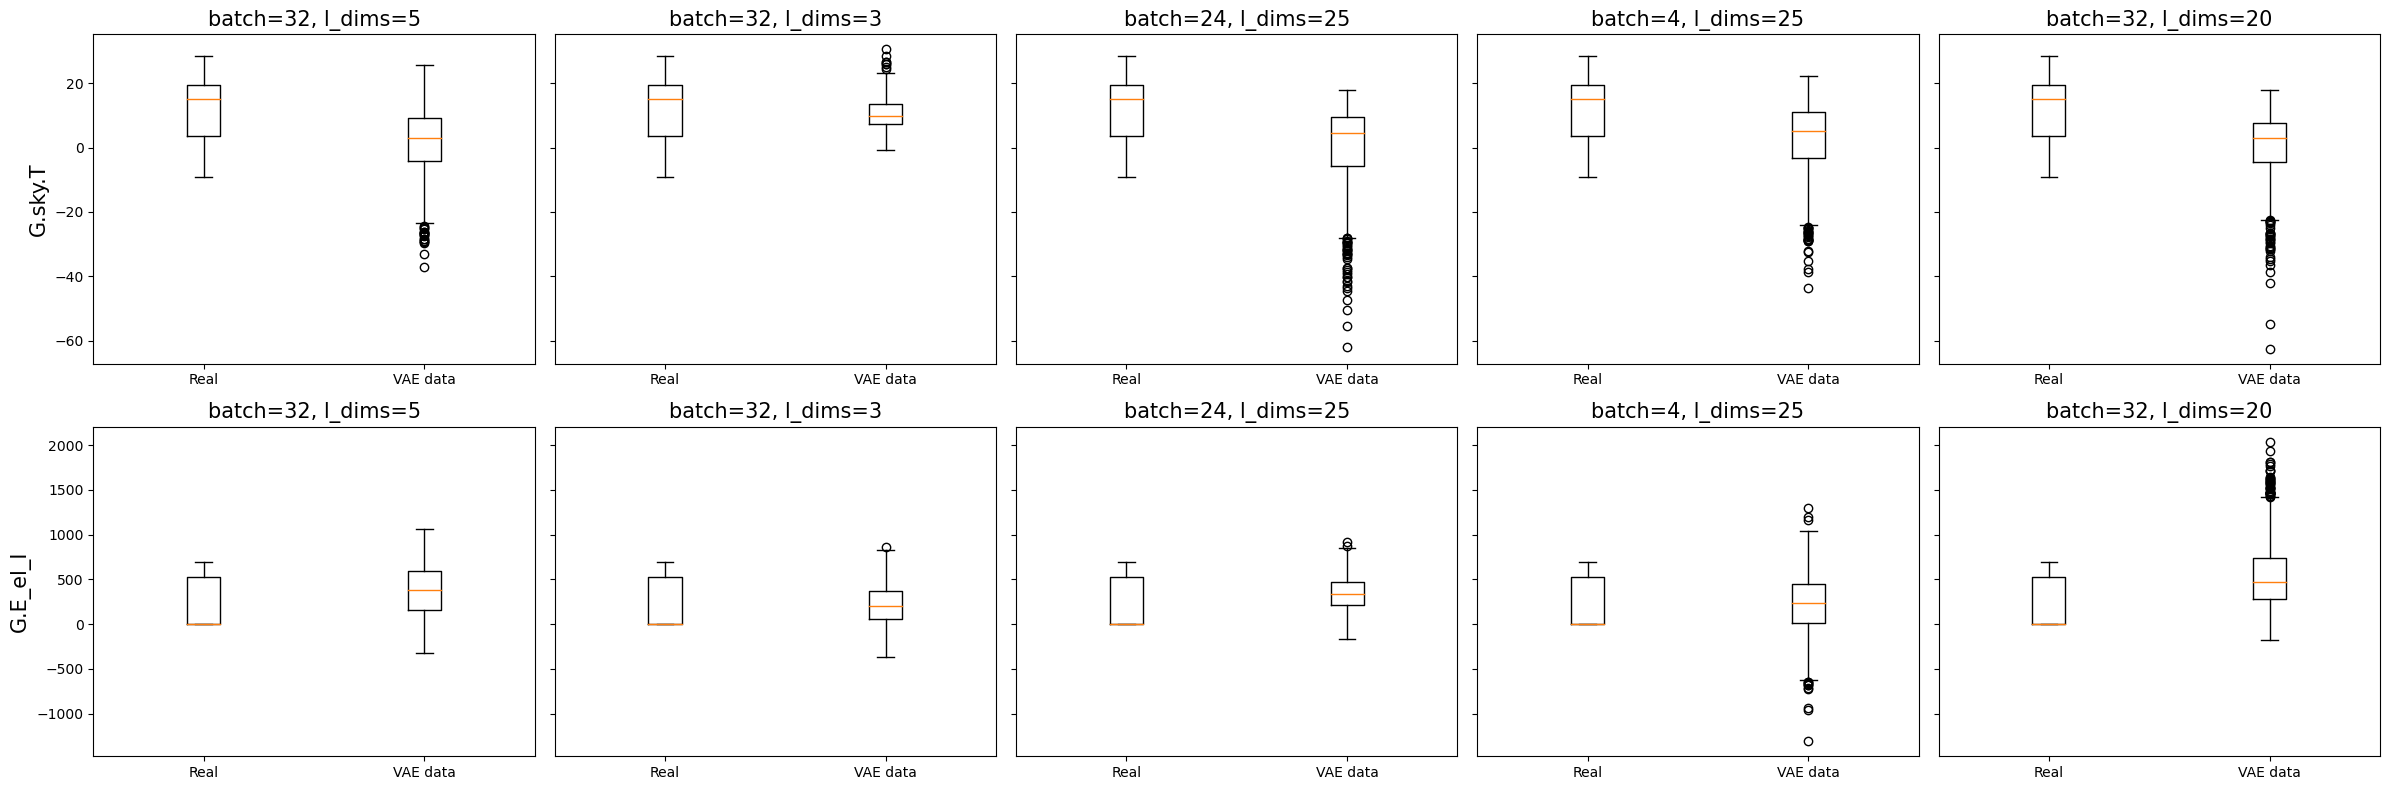

In [126]:
import re

fig, ax = plt.subplots(2, 5, figsize=(24,8), sharey='row')

for column_name in [0,1]:
    real_df = pd.DataFrame(base_data[:,:,column_name])
    df_list = [pd.DataFrame(df[:,:,column_name]) for df in vae_data]



    for i, df in enumerate(df_list):
        match = re.search(f'b(\d+)l(\d+)', vae_files[i])
        b, l = match.groups()

        ax[column_name, i].set_title(f'batch={b}, l_dims={l}', fontsize=15)
        ax[column_name, i].boxplot([real_df[0].values, df[0].values], labels=['Real', 'VAE data'])
    
ax[0,0].set_ylabel('G.sky.T', fontsize=15)
ax[1,0].set_ylabel('G.E_el_I', fontsize=15)
plt.tight_layout()
    
plt.savefig(f'../imgs/vae_data/{model_name}_boxplot_comparisons.png')

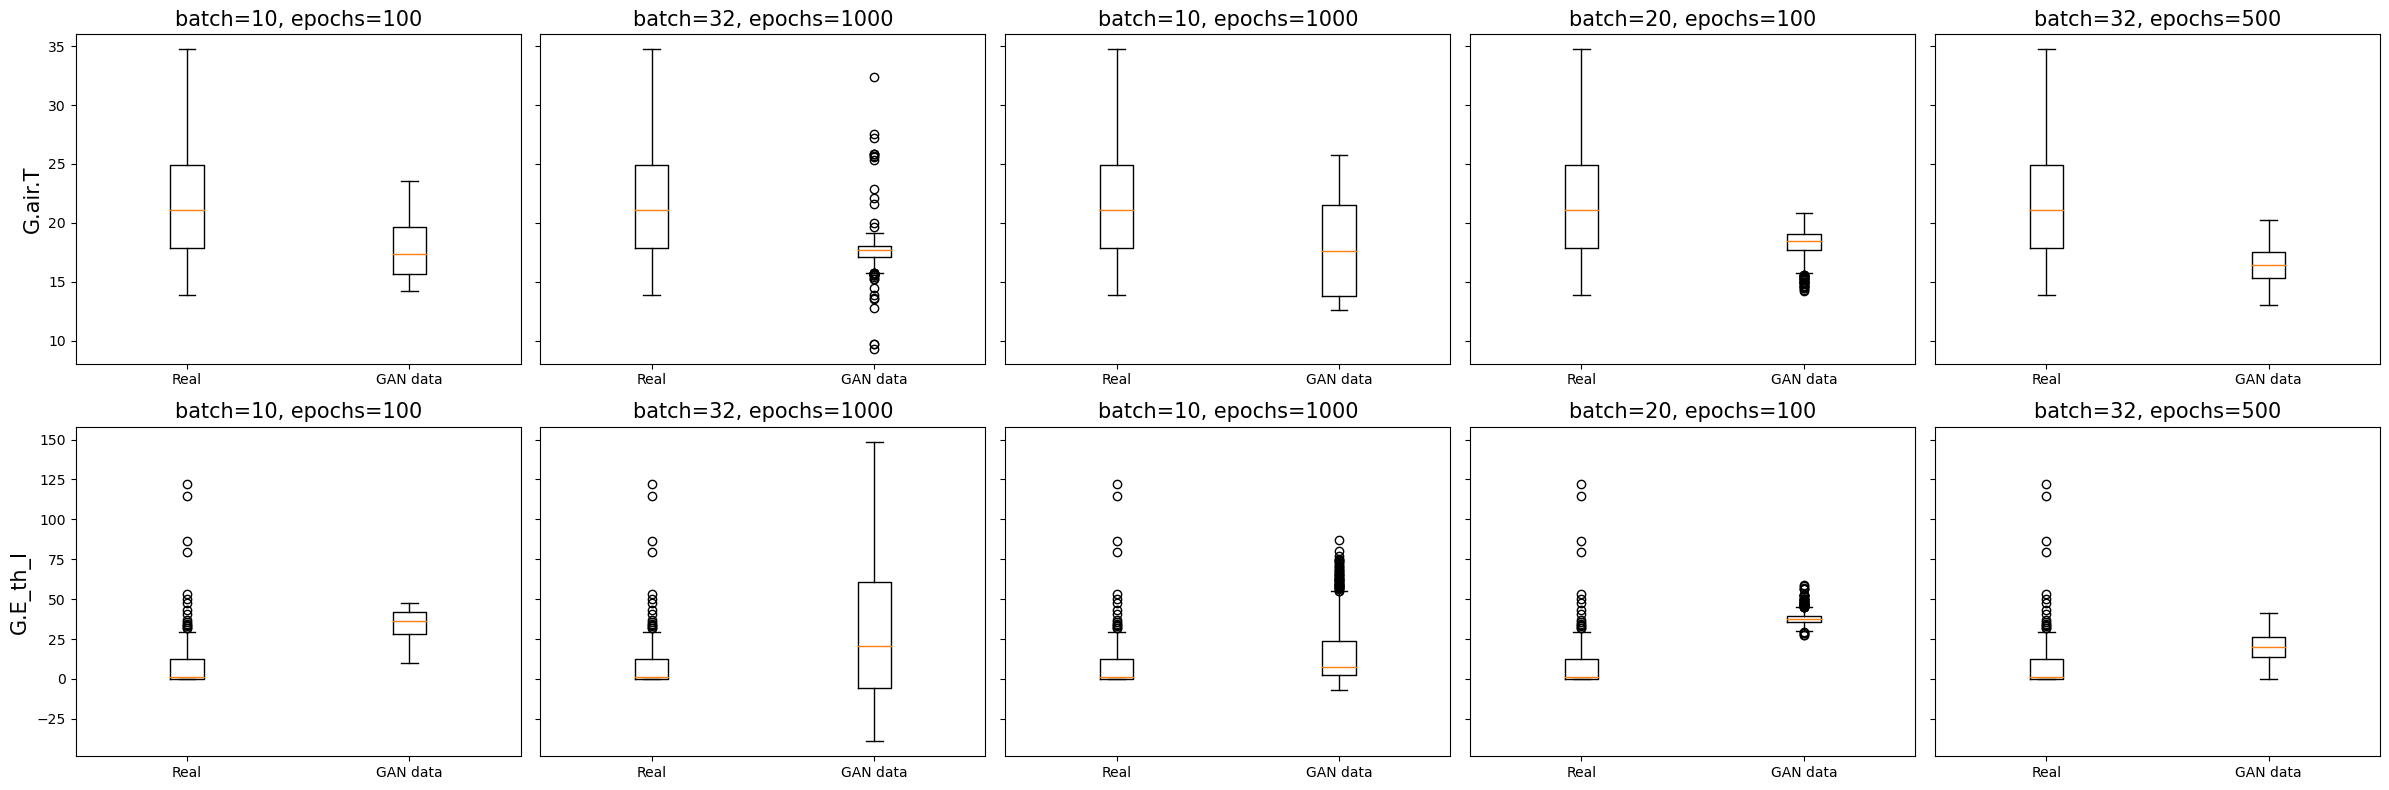

In [120]:
import re

fig, ax = plt.subplots(2, 5, figsize=(24,8), sharey='row')

for column_name in [0,1]:
    real_df = pd.DataFrame(base_data[:,:,column_name])
    df_list = [pd.DataFrame(df[:,:,column_name]) for df in gan_data]

    for i, df in enumerate(df_list):
        match = re.search(f'b(\d+)e(\d+)', gan_files[i])
        b, e = match.groups()

        ax[column_name, i].set_title(f'batch={b}, epochs={e}', fontsize=15)
        ax[column_name, i].boxplot([real_df[0].values, df[0].values], labels=['Real', 'GAN data'])
    
ax[0,0].set_ylabel('G.sky.T', fontsize=15)
ax[1,0].set_ylabel('G.E_el_I', fontsize=15)
plt.tight_layout()
    
plt.savefig(f'../imgs/gan_data/{model_name}_boxplot_comparisons.png')

In [8]:
features = ['G.air.T', 'G.E_th_I'] if MODEL==0 else ['G.sky.T', 'G.E_el_I']

<h3> Plots </h3>

In [9]:
def plot_box(real_data, fake_data, dir):
    sns.set(style="whitegrid")
    
    real_feature1, real_feature2 = real_data[:,:,0].flatten(), real_data[:,:,1].flatten()
    fake_feature1, fake_feature2 = fake_data[:,:,0].flatten(), fake_data[:,:,1].flatten()

    for index, feature in enumerate(features):
        data = {
            'Value': np.concatenate([real_data[:, :, index].flatten(), fake_data[:, :, index].flatten()]),
            'Type': ['Ground Truth'] * len(real_data[:, :, index].flatten()) + ['Synthetic (VAE)'] * len(fake_data[:, :, index].flatten()),
            'Feature': [feature] * (len(real_data[:, :, index].flatten()) + len(fake_data[:, :, index].flatten()))
        }

        # Plotting
        plt.figure(figsize=(8, 8))
        sns.boxplot(x='Feature', y='Value', hue='Type', data=pd.DataFrame(data), palette="Set2")
        plt.title(f'Boxplot Comparison of Ground Truth and Synthetic Data for {feature}')
        plt.xlabel('')
        plt.show()#plt.savefig(f'../imgs/{dir}/{feature}_boxplots.png')

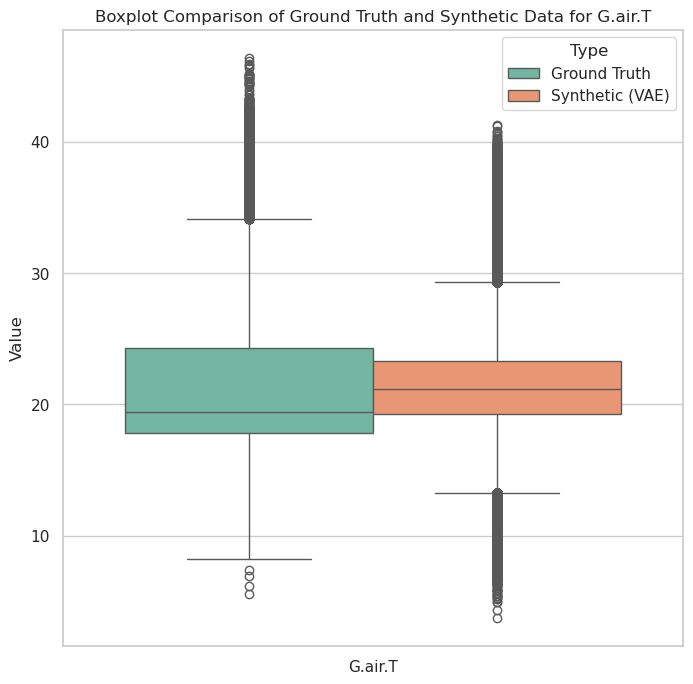

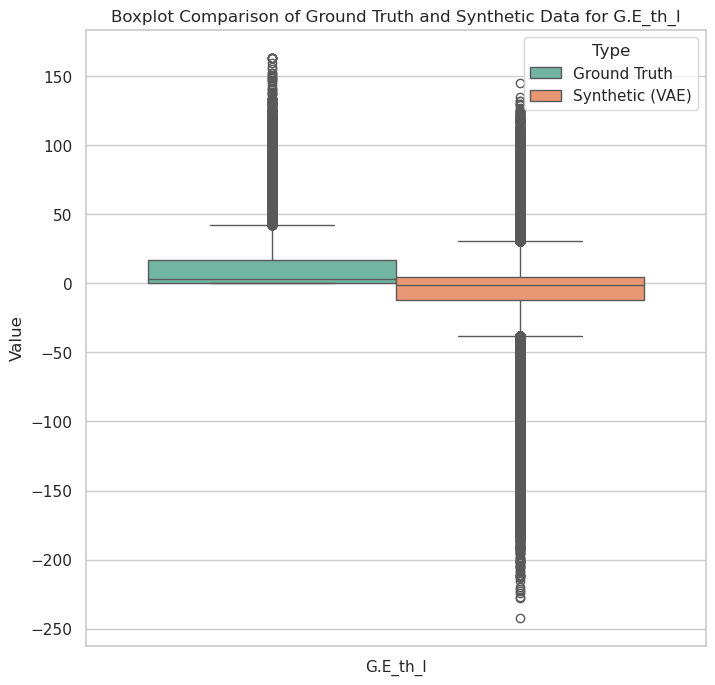

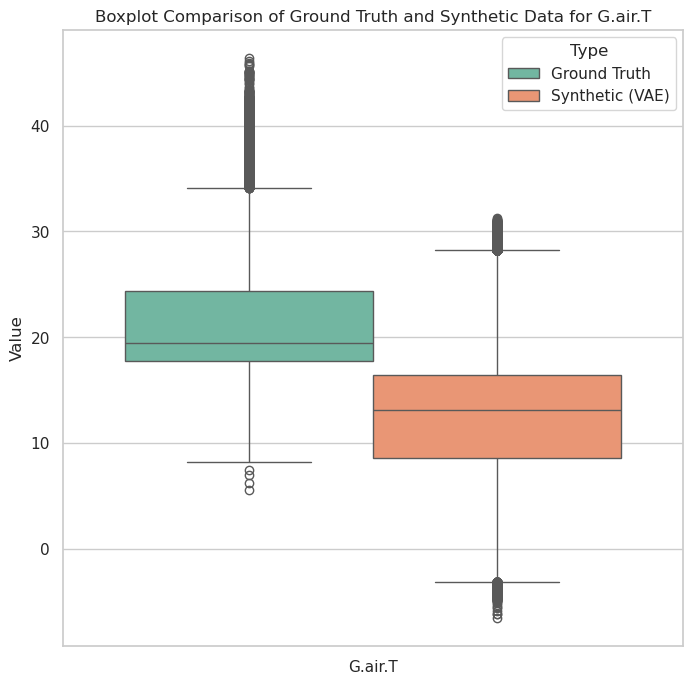

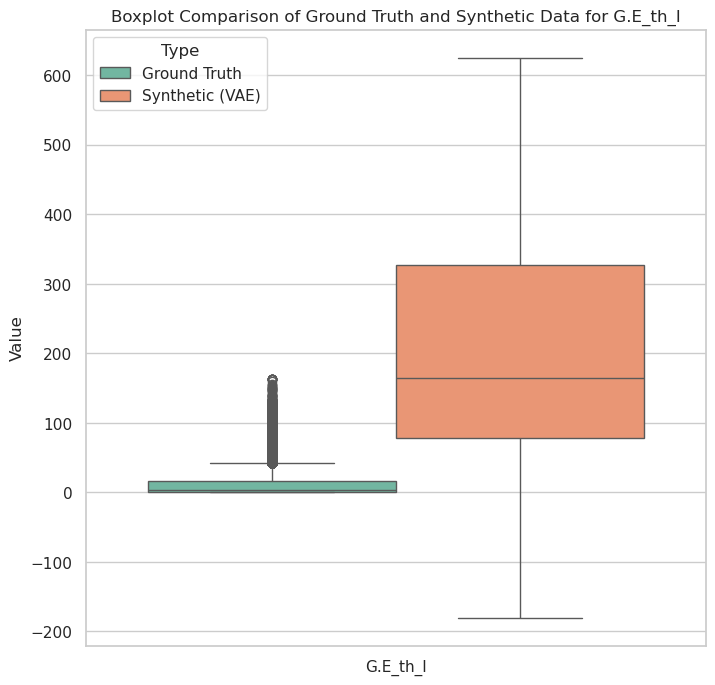

In [10]:
plot_box(base_data, vae_data, 'vae_data')
plot_box(base_data, gan_data, 'gan_data')

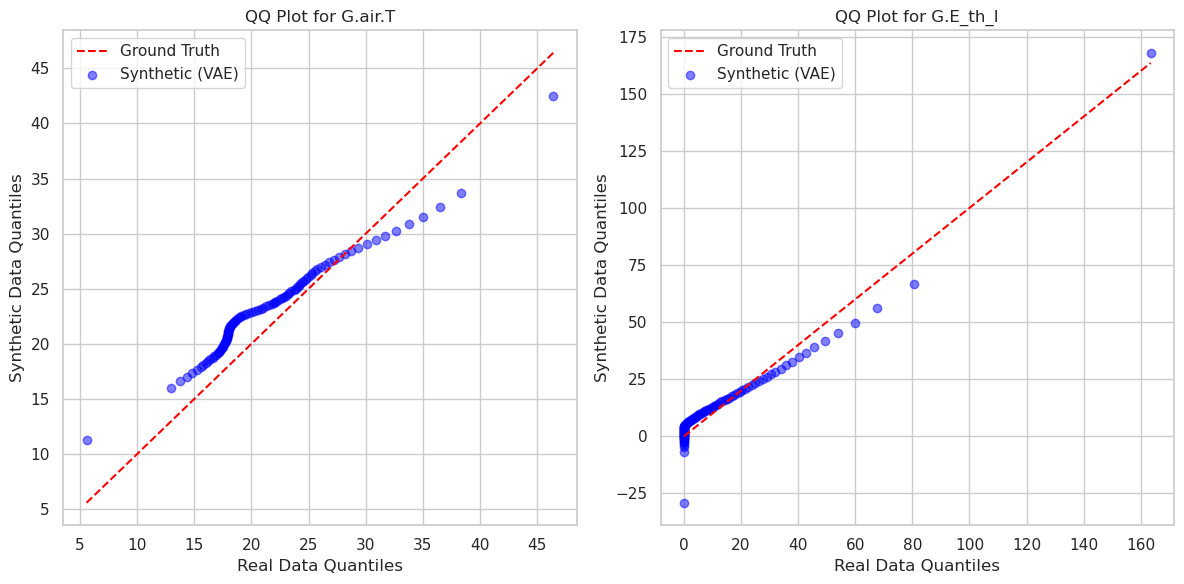

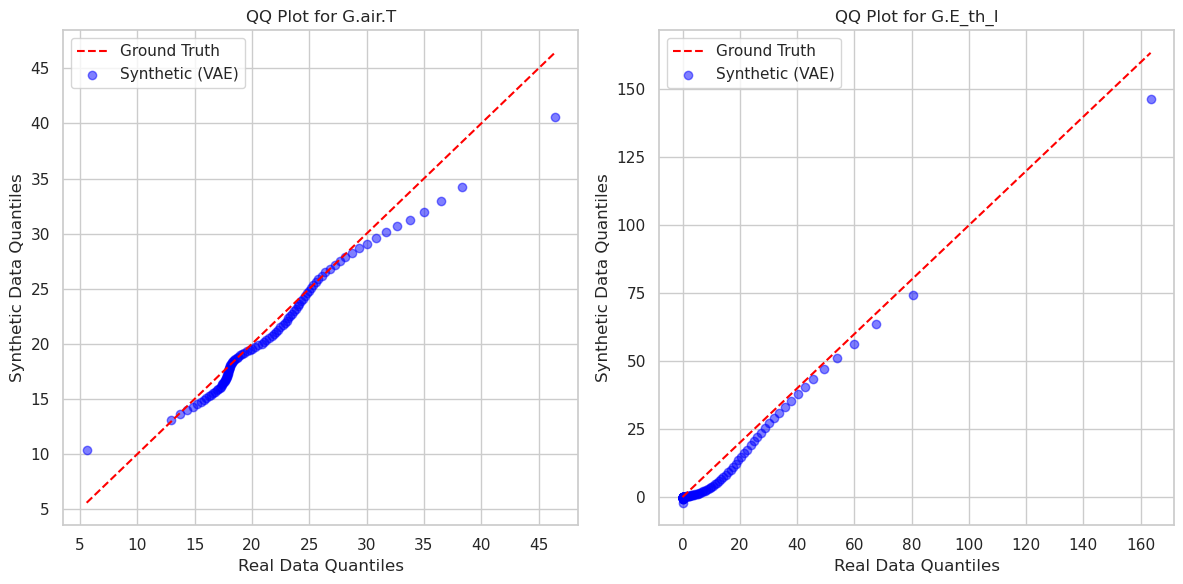

In [9]:
from scipy import stats
def plot_qq(real_data, synthetic_data, dir):
    sns.set(style="whitegrid")
    # Create a figure with two subplots (side by side)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    for feature_index, feature in enumerate(features):
        ax = axes[feature_index]
        # Flatten the data for the current feature
        real_data_flattened = real_data[:,:,feature_index].flatten()
        synthetic_data_flattened = synthetic_data[:,:,feature_index].flatten()

        # Create dataframes
        real_df = pd.DataFrame(real_data_flattened, columns=['Real Data'])
        synthetic_df = pd.DataFrame(synthetic_data_flattened, columns=['Synthetic Data'])
        
        # Ensure synthetic data has the same number of points as real data
        synthetic_df = synthetic_df.iloc[:len(real_df)]

        # Calculate quantiles
        quantiles = np.linspace(0, 1, 100)
        real_quantiles = np.quantile(real_df, quantiles)
        synthetic_quantiles = np.quantile(synthetic_df, quantiles)

        # Plotting on the current axis (ax)
        ax.plot(real_quantiles, real_quantiles, linestyle='--', color='red', label='Ground Truth')
        ax.scatter(real_quantiles, synthetic_quantiles, color='blue', alpha=0.5, label='Synthetic (VAE)')
        ax.set_xlabel('Real Data Quantiles')
        ax.set_ylabel('Synthetic Data Quantiles')
        ax.set_title(f'QQ Plot for {feature}')
        ax.legend()

    plt.tight_layout()
    plt.show()#plt.savefig(f'../imgs/{dir}/{model_name}_qq.png')


plot_qq(base_data, vae_data, 'vae_data')
plot_qq(base_data, gan_data, 'gan_data')

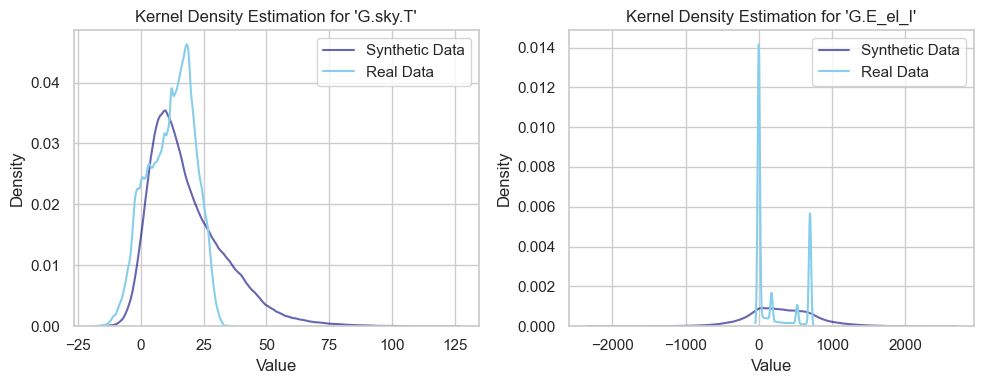

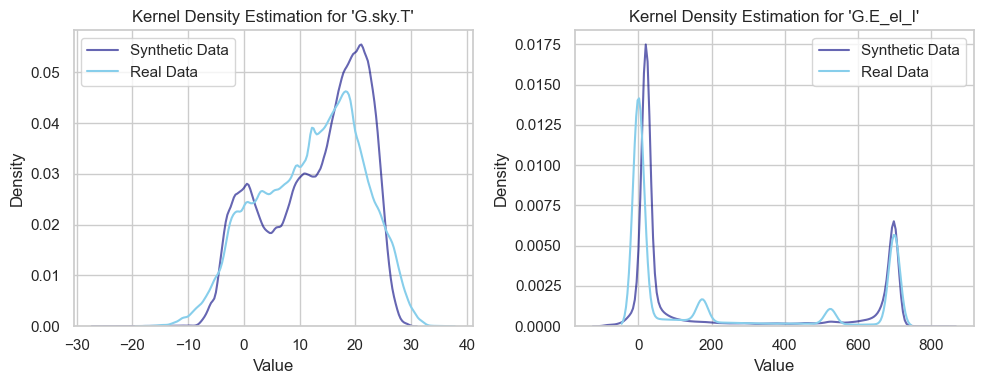

In [46]:
def plot_kde(synthetic_data, real_data, dir):
    sns.set(style="whitegrid")

    # Create a figure with two subplots (side by side)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    for feature_index, feature in enumerate(features):
        ax = axes[feature_index]
        synthetic_feature_values = synthetic_data[:, :, feature_index].flatten()
        real_feature_values = real_data[:, :, feature_index].flatten()

        sns.kdeplot(synthetic_feature_values, label="Synthetic Data", bw_adjust=0.5, color="navy", alpha=0.6, ax=ax)
        sns.kdeplot(real_feature_values, label="Real Data", bw_adjust=0.5, color="skyblue", ax=ax)

        ax.set_title(f"Kernel Density Estimation for '{features[feature_index]}'")
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend()

    plt.tight_layout()
    plt.show()#plt.savefig(f'../imgs/{dir}/{model_name}_kde.png')


plot_kde(vae_data, base_data, 'vae_data')
plot_kde(gan_data, base_data, 'gan_data')

<h3> Statistical measures </h3>

In [60]:
base_data_flat, vae_data_flat, gan_data_flat = base_data.reshape(-1,2), vae_data.reshape(-1,2), gan_data.reshape(-1,2)

print('Real', pd.DataFrame(base_data_flat,columns=features).describe(), '\n')
print('VAE', pd.DataFrame(vae_data_flat,columns=features).describe(), '\n')
print('GAN', pd.DataFrame(gan_data_flat,columns=features).describe(), '\n')

Real             G.air.T      G.E_th_I
count  78840.000000  7.884000e+04
mean      21.416501  1.165378e+01
std        5.398225  1.811206e+01
min        5.580089 -2.651068e-07
25%       17.784281  0.000000e+00
50%       19.423142  2.886869e+00
75%       24.321731  1.699295e+01
max       46.410364  1.634586e+02 

VAE              G.air.T       G.E_th_I
count  730000.000000  730000.000000
mean       24.725332      18.347784
std         7.561875      23.194775
min       -11.619044     -73.958870
25%        20.207055       2.989005
50%        23.978162      11.525747
75%        28.833932      26.721427
max        76.445511     274.913086 

GAN              G.air.T       G.E_th_I
count  730000.000000  730000.000000
mean       20.745037       8.869612
std         5.084542      16.828659
min        10.024977      -2.883958
25%        16.937551      -0.152235
50%        19.294590       0.494473
75%        23.983215       9.789294
max        41.863750     171.028137 



In [61]:
print('Real', pd.DataFrame(base_data_flat,columns=features).skew(), '\n')
print('VAE', pd.DataFrame(vae_data_flat,columns=features).skew(), '\n')
print('GAN', pd.DataFrame(gan_data_flat,columns=features).skew(), '\n')

Real G.air.T     1.166710
G.E_th_I    2.319869
dtype: float64 

VAE G.air.T     0.431215
G.E_th_I    2.028752
dtype: float32 

GAN G.air.T     0.832871
G.E_th_I    2.472083
dtype: float32 



In [62]:
print('Real', pd.DataFrame(base_data_flat,columns=features).kurtosis(), '\n')
print('VAE', pd.DataFrame(vae_data_flat,columns=features).kurtosis(), '\n')
print('GAN', pd.DataFrame(gan_data_flat,columns=features).kurtosis(), '\n')

Real G.air.T     1.279467
G.E_th_I    6.829065
dtype: float64 

VAE G.air.T     1.395421
G.E_th_I    6.631658
dtype: float32 

GAN G.air.T     0.034017
G.E_th_I    6.770422
dtype: float32 



<h3> Loss curves </h3>

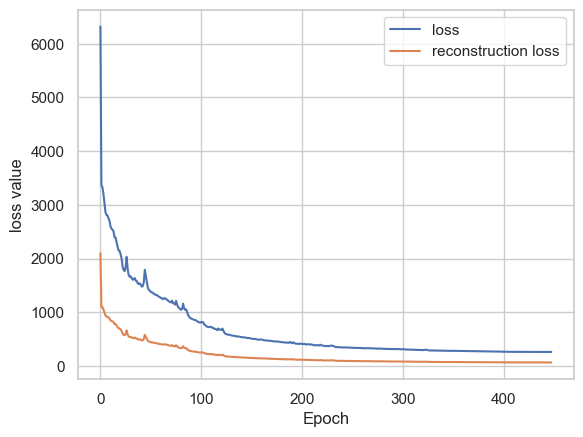

In [38]:
loss = pd.read_csv(f'../data/models/model_history/{model_name}_loss.csv')
plt.plot(loss['loss'], label='loss')
plt.plot(loss['reconstruction_loss'], label='reconstruction loss')
plt.xlabel('Epoch')
plt.ylabel('loss value')
plt.legend()
plt.savefig(f'../imgs/vae_data/{model_name}_loss_curve.png')

In [26]:
import scipy.stats as stats

def plot_qq(real_data, synthetic_data):
    real_data = real_data.iloc[:len(synthetic_data)]

    quantiles = np.linspace(0,1,100)

    num_features = real_data.shape[1]
    fig, axs = plt.subplots(1, num_features, figsize=(5*num_features, 5), squeeze=False)

    for i in range(num_features):
        real_quantiles = np.quantile(real_data.iloc[:, i], quantiles)
        synthetic_quantiles = np.quantile(synthetic_data.iloc[:, i], quantiles)

        ax = axs[0,i]
        ax.plot(real_quantiles, real_quantiles, linestyle='--', color='red', label='Real Data')
        ax.scatter(real_quantiles, synthetic_quantiles, color='blue', alpha=0.5, label='Synthetic Data')

        ax.set_xlabel('Real Data Quantiles')
        ax.set_ylabel('Synthetic Data Quantiles')
        ax.title.set_text(f'{i+1}')

    plt.tight_layout()
    plt.show()

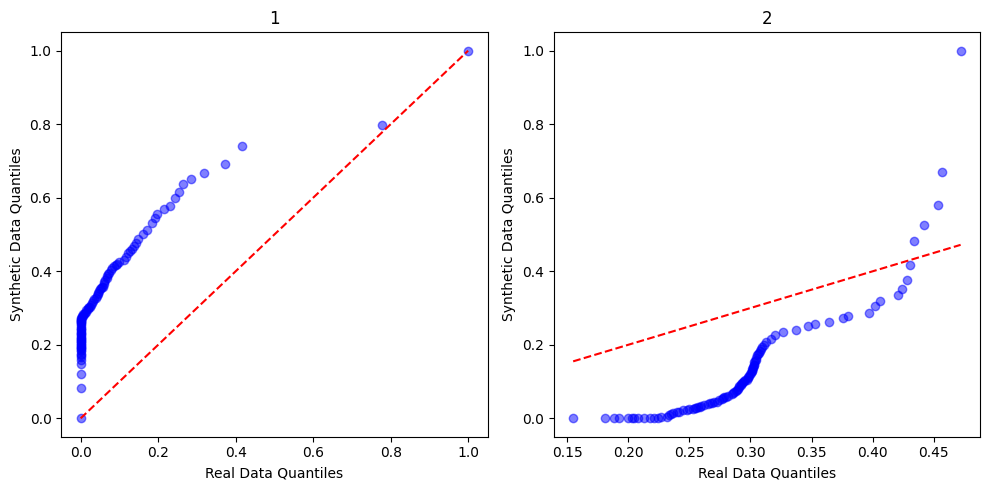

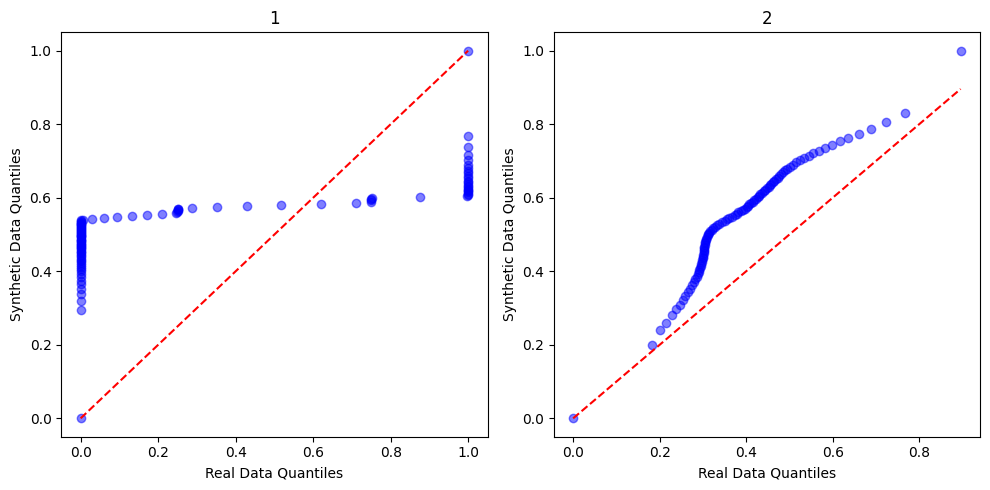

In [27]:
plot_qq(base_data[['G.E_th_I', 'G.air.T']].copy(), new_vae_scaled.copy())
plot_qq(base_data[['G.E_el_I', 'G.air.T']].copy(), new_gan_scaled.copy())

In [10]:
def plot_kde(synthetic_data, real_data):
    sns.set(style="whitegrid")

    plt.figure(figsize=(10,6))
    sns.kdeplot(synthetic_data['G.air.T'], label="Synthetic Data", bw_adjust=0.5, color="navy", alpha=0.6)
    sns.kdeplot(real_data['G.air.T'], label="Real Data", bw_adjust=0.5, color="skyblue")

    plt.title("Kernal Density Estimation for Synthetic and Real Data 'G.air.T'")
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    sns.kdeplot(synthetic_data['G.E_el_I'], label="Synthetic Data", bw_adjust=0.5, color="navy", alpha=0.6)
    sns.kdeplot(real_data['G.E_el_I'], label="Real Data", bw_adjust=0.5, color="skyblue")

    plt.title("Kernal Density Estimation for Synthetic and Real Data 'G.E_el_I'")
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

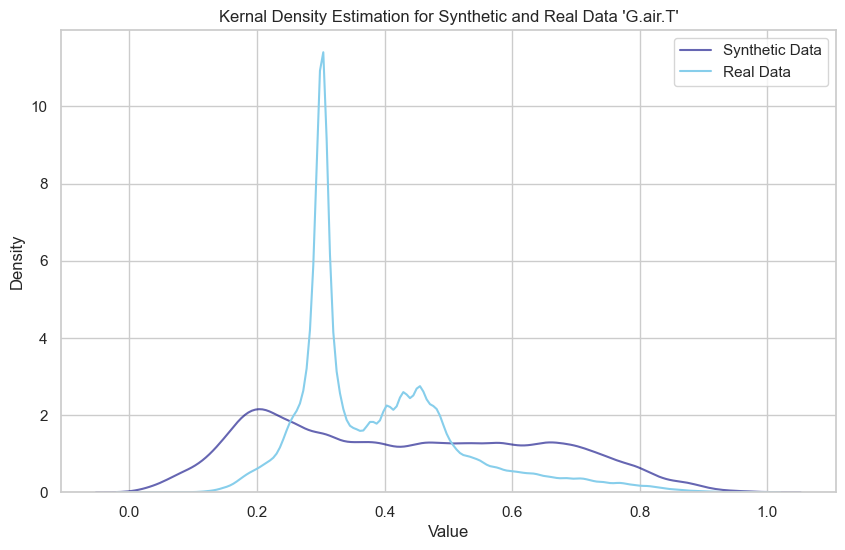

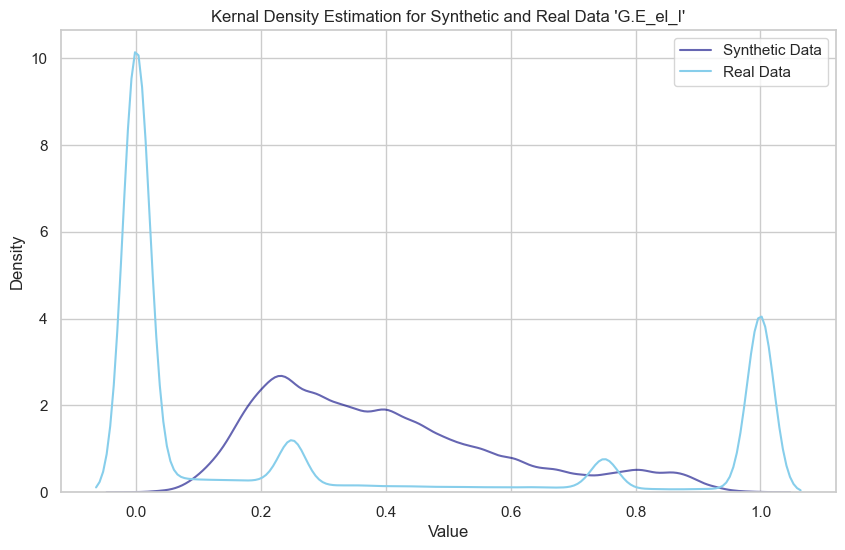

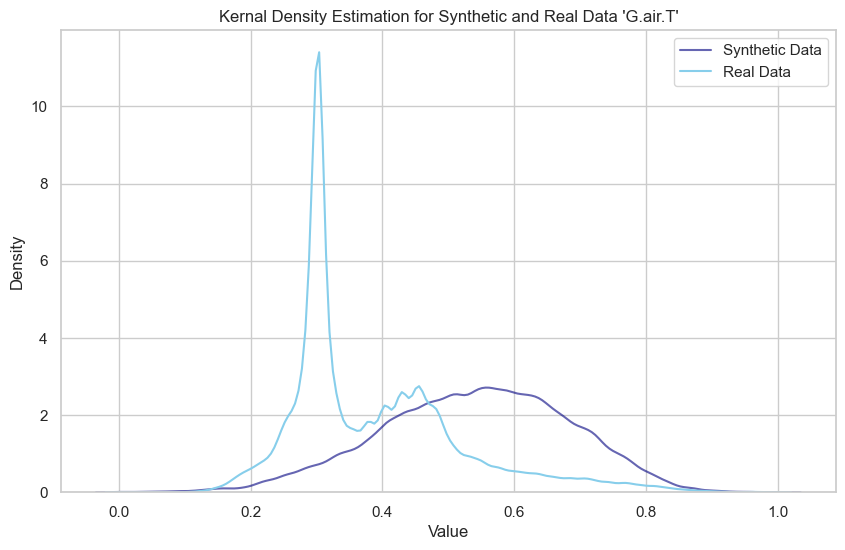

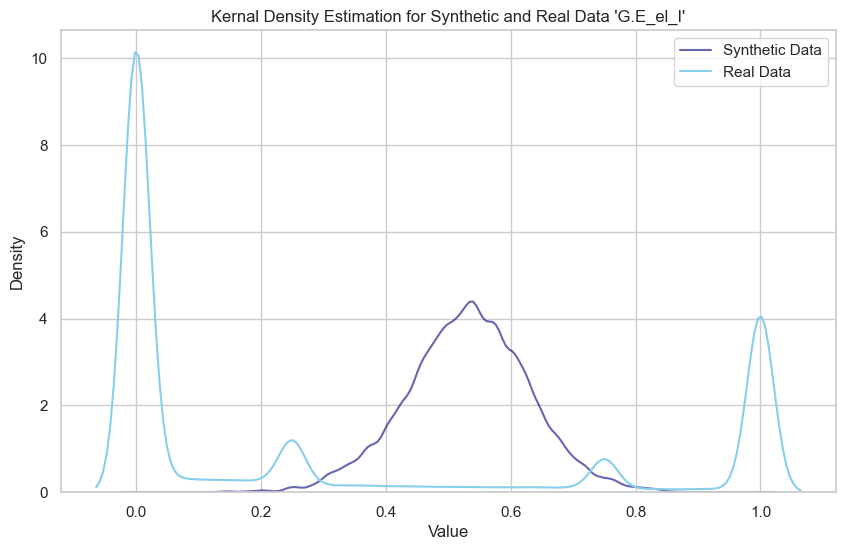

In [11]:
plot_kde(new_vae_scaled.copy(), base_data[['G.E_el_I', 'G.air.T']].copy())
plot_kde(new_gan_scaled.copy(), base_data[['G.E_el_I', 'G.air.T']].copy())

In [12]:
base_data['G.air.T'], new_vae_scaled['G.air.T']
new_vae_scaled.index = base_data[:8759*3600].index
new_gan_scaled.index = base_data[:8759*3600].index

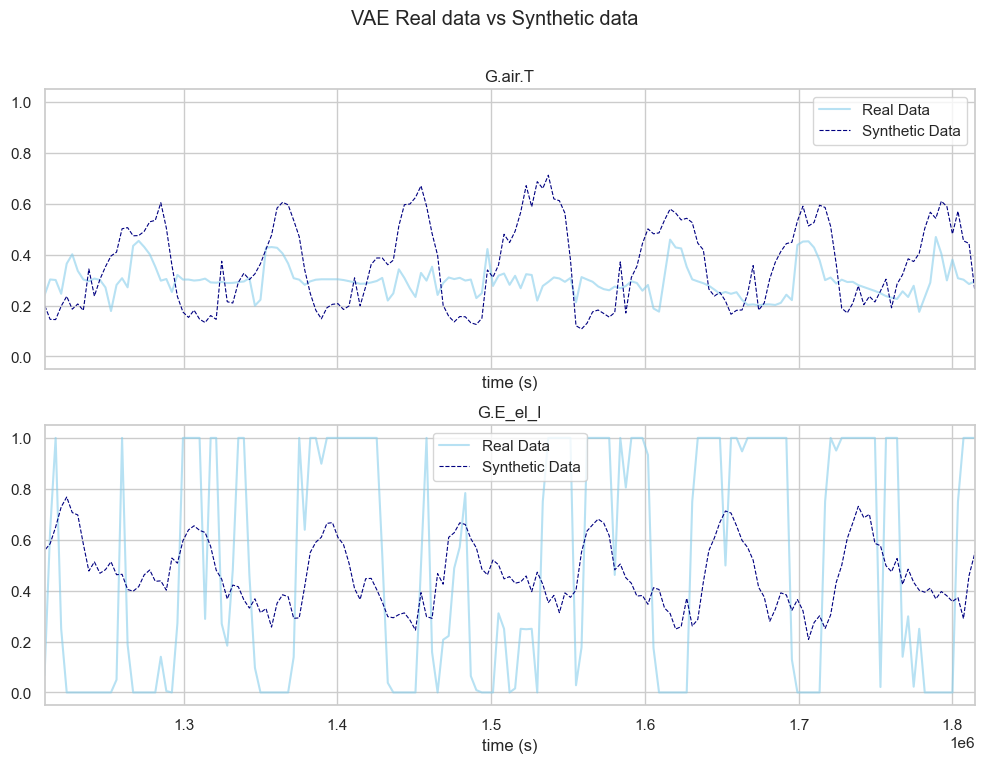

In [62]:
week_secs = 24*7*3600
start_week, end_week = 2, 3

vae_offset, gan_offset = 10, 0
x_base = np.arange(len(base_data['G.air.T']))
x_vae, x_gan = np.arange(vae_offset, len(new_vae_scaled['G.air.T']) + vae_offset), \
               np.arange(gan_offset, len(new_gan_scaled['G.air.T']) + gan_offset)

fig, ax = plt.subplots(2, figsize=(12,8), sharex=True)
fig.suptitle('VAE Real data vs Synthetic data')

ax[0].plot(x_base*3600, base_data['G.air.T'], color='skyblue', alpha=0.6, label='Real Data')
ax[0].plot(x_vae*3600, new_vae_scaled['G.air.T'], color='navy', label='Synthetic Data', linestyle='--', linewidth=0.8)
ax[0].set_xlim(week_secs*start_week, week_secs*end_week)
ax[0].set_title('G.air.T')
ax[0].legend()
ax[0].set_xlabel('time (s)')

ax[1].plot(x_base*3600, base_data['G.E_el_I'], color='skyblue', alpha=0.6, label='Real Data')
ax[1].plot(x_vae*3600, new_vae_scaled['G.E_el_I'], color='navy', label='Synthetic Data', linestyle='--', linewidth=0.8)
ax[1].set_xlim(week_secs*start_week, week_secs*end_week)
ax[1].set_title('G.E_el_I')
ax[1].legend()
ax[1].set_xlabel('time (s)')

plt.savefig('../images/real_vs_synth_vae_1.png')

[  10   11   12 ... 8767 8768 8769] [   0    1    2 ... 8757 8758 8759]


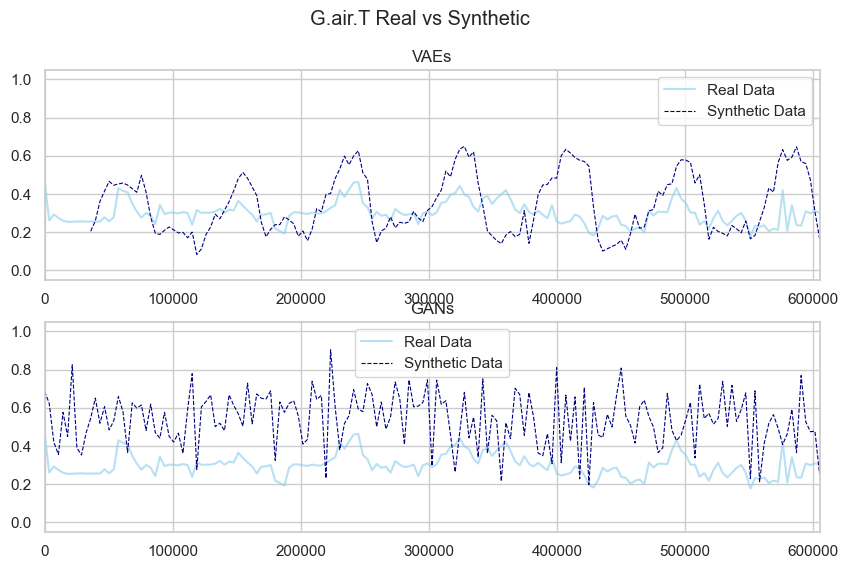

In [13]:
week_secs = 24*7*3600
start_week, end_week = 0, 1

vae_offset, gan_offset = 10, 0
x_base = np.arange(len(base_data['G.air.T']))
x_vae, x_gan = np.arange(vae_offset, len(new_vae_scaled['G.air.T']) + vae_offset), \
               np.arange(gan_offset, len(new_gan_scaled['G.air.T']) + gan_offset)

print(x_vae, x_gan)

fig, ax = plt.subplots(2, figsize=(10,6))
ax[0].plot(x_base*3600, base_data['G.air.T'], color='skyblue', alpha=0.6, label='Real Data')
ax[0].plot(x_vae*3600, new_vae_scaled['G.air.T'], color='navy', label='Synthetic Data', linestyle='--', linewidth=0.8)
ax[0].set_xlim(week_secs*start_week, week_secs*end_week)
ax[0].set_title('VAEs')
ax[0].legend()

ax[1].plot(x_base*3600, base_data['G.air.T'], color='skyblue', alpha=0.6, label='Real Data')
ax[1].plot(x_gan*3600, new_gan_scaled['G.air.T'], color='navy', label='Synthetic Data', linestyle='--', linewidth=0.8)
ax[1].set_xlim(week_secs*start_week, week_secs*end_week)
ax[1].set_title('GANs')
ax[1].legend()

fig.suptitle('G.air.T Real vs Synthetic')
plt.show()

[  10   11   12 ... 8767 8768 8769] [   0    1    2 ... 8757 8758 8759]


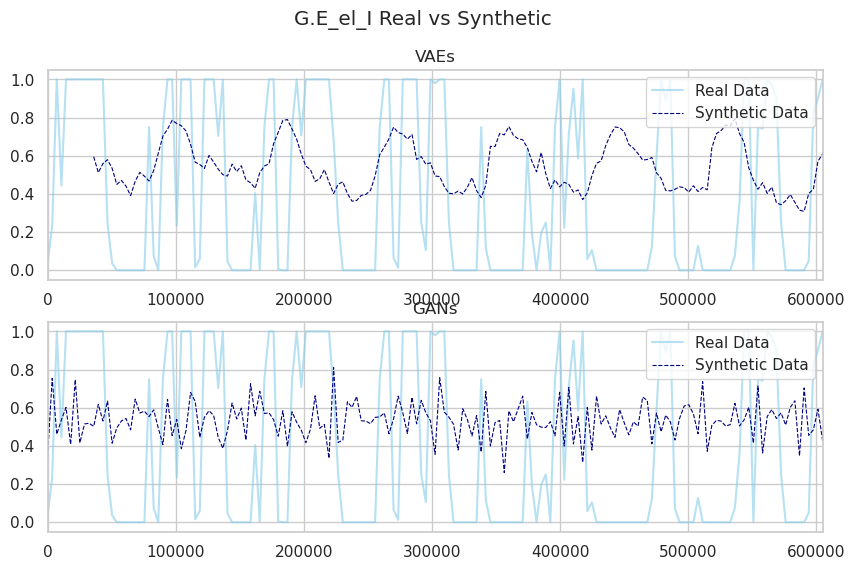

In [20]:
week_secs = 24*7*3600
start_week, end_week = 0, 1

vae_offset, gan_offset = 10, 0
x_base = np.arange(len(base_data['G.E_el_I']))
x_vae, x_gan = np.arange(vae_offset, len(new_vae_scaled['G.E_el_I']) + vae_offset), \
               np.arange(gan_offset, len(new_gan_scaled['G.E_el_I']) + gan_offset)

print(x_vae, x_gan)

fig, ax = plt.subplots(2, figsize=(10,6))
ax[0].plot(x_base*3600, base_data['G.E_el_I'], color='skyblue', alpha=0.6, label='Real Data')
ax[0].plot(x_vae*3600, new_vae_scaled['G.E_el_I'], color='navy', label='Synthetic Data', linestyle='--', linewidth=0.8)
ax[0].set_xlim(week_secs*start_week, week_secs*end_week)
ax[0].set_title('VAEs')
ax[0].legend()

ax[1].plot(x_base*3600, base_data['G.E_el_I'], color='skyblue', alpha=0.6, label='Real Data')
ax[1].plot(x_gan*3600, new_gan_scaled['G.E_el_I'], color='navy', label='Synthetic Data', linestyle='--', linewidth=0.8)
ax[1].set_xlim(week_secs*start_week, week_secs*end_week)
ax[1].set_title('GANs')
ax[1].legend()

fig.suptitle('G.E_el_I Real vs Synthetic')
plt.show()